In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import joblib
from sklearn.tree import DecisionTreeClassifier, plot_tree, ExtraTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from sklearn.impute import KNNImputer
import warnings

warnings.filterwarnings("ignore")
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/"

In [2]:
# Load data
df_train = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Training")
df_valid = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Validate")
df_train.shape,df_valid.shape

((10000, 33), (20000, 33))

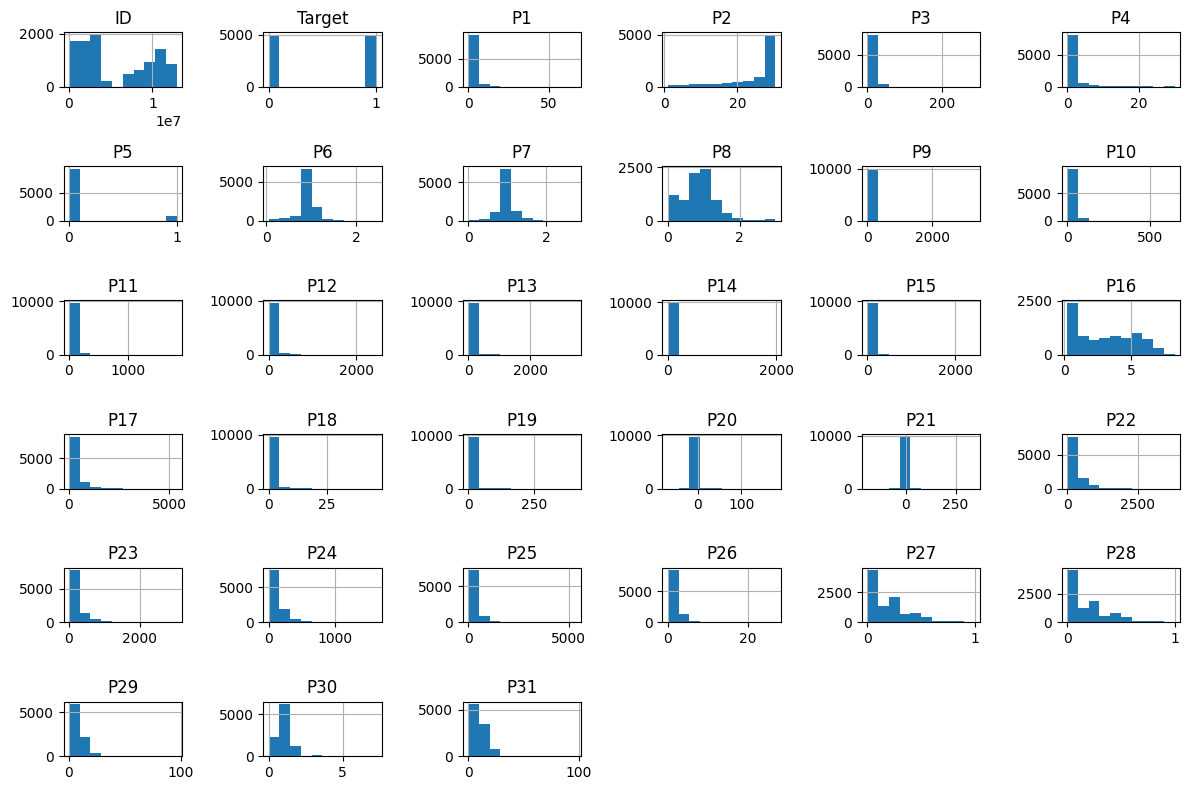

In [3]:
#Exploratory
df_train.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

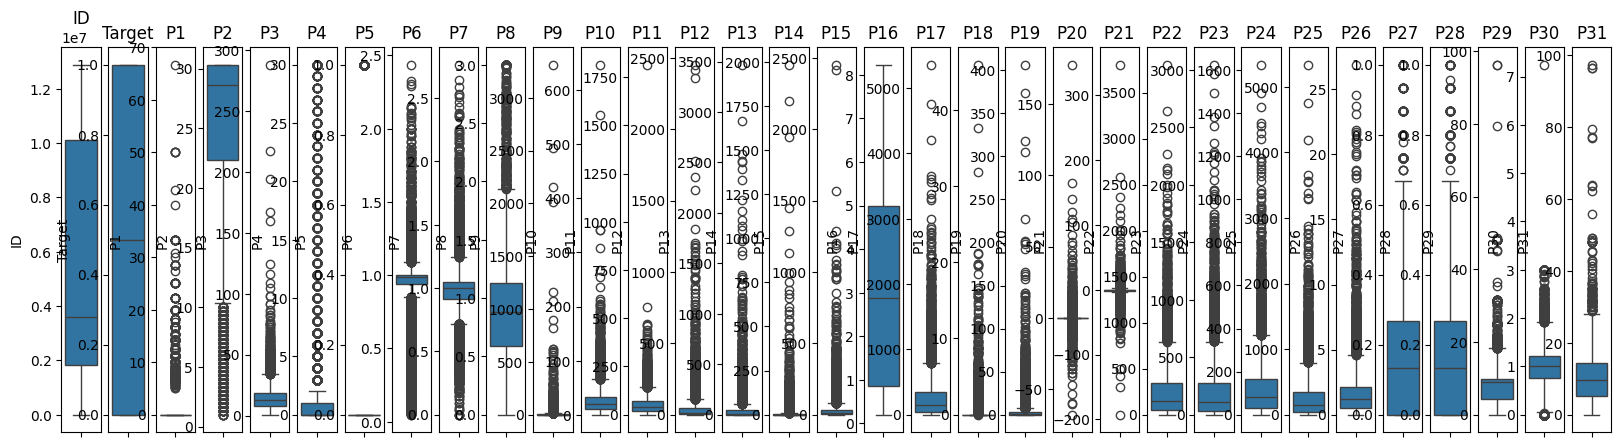

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=len(df_train.columns), figsize=(20, 5))

for i, column in enumerate(df_train.columns):
    sns.boxplot(data=df_train, y=column, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout() 
plt.show()

In [3]:
features = [
    column for column in df_train.columns if column.startswith("P")
]                                                               # list feature names
target = "Target"
X, y = df_train[features].values, df_train[target].values
X_v = df_valid[features].values

print(X.shape, y.shape)
print(X_v.shape)
print('Nan in df_train:', np.isnan(X).sum(axis=0))                                 # check Nan
print('Nan in df_validate:', np.isnan(X_v).sum(axis=0))                             # check Nan
print('1 in df_train:', np.isin(y, 1).sum())                                     # check balance 0 and 1 in train

(10000, 31) (10000,)
(20000, 31)
Nan in df_train: [   0 1508 1477    0    0    0    0 1518    0    0    0    0    0    0
    0 1525    0    0    0    0    0    0    0    0 1504    0    0    0
 1533    0    0]
Nan in df_validate: [   0 2968 2979    0    0    0    0 3015    0    0    0    0    0    0
    0 3003    0    0    0    0    0    0    0    0 3021    0    0    0
 3013    0    0]
1 in df_train: 5000


In [4]:
# replace Nan
nan = np.nan
imputer = KNNImputer(n_neighbors=8, weights="uniform")
X_inp = imputer.fit_transform(X)
X_val = imputer.transform(X_v)

print('Nan in df_train:', np.isnan(X_inp).sum(axis=0))   
print('Nan in df_validate:', np.isnan(X_val).sum(axis=0))

# from sklearn.impute import SimpleImputer            
# # Замена на медиану
# imputer = SimpleImputer(strategy='median')
# X_inp = imputer.fit_transform(X)
# X_val = imputer.transform(X_v)
# nan = np.nan

# print('Nan in df_train:', np.isnan(X_inp).sum(axis=0))   
# print('Nan in df_validate:', np.isnan(X_val).sum(axis=0))

Nan in df_train: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Nan in df_validate: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
X_train, X_test, y_train, y_test, = train_test_split(X_inp, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape

((8000, 31), (2000, 31))

In [6]:
# Create model
model_1 = DecisionTreeClassifier(random_state=42, class_weight="balanced")
param_grid_1 = {
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_depth': [3, 5, 7, None],      # Max depth 
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

grid_search_1 = GridSearchCV(
    estimator=model_1,          
    param_grid=param_grid_1,    
    cv=5,                     
    scoring='accuracy',       
    n_jobs=7,                 # CPU
    verbose=1                 
)
     
result_1 = grid_search_1.fit(X_train, y_train)
print("Best param:", result_1.best_params_)
best_model_1 = result_1.best_estimator_

y_score_1 = best_model_1.predict_proba(X_test)[:, 1]    # returns the probabilities  to a class 1
y_pred_1 = best_model_1.predict(X_test)
y_score_1.shape, y_pred_1.shape

dict(
    roc_1 = roc_auc_score(y_score=y_score_1, y_true=y_test), 
    recall_1 = recall_score(y_pred=y_pred_1, y_true=y_test),
    accuracy_1 = accuracy_score (y_pred=y_pred_1, y_true=y_test),
    precision_1 = precision_score(y_pred=y_pred_1, y_true=y_test),
    f1_1 = f1_score(y_pred=y_pred_1, y_true=y_test),
    confusion_mat_1 = confusion_matrix(y_pred=y_pred_1, y_true=y_test)
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best param: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


{'roc_1': 0.729168,
 'recall_1': 0.591,
 'accuracy_1': 0.668,
 'precision_1': 0.6985815602836879,
 'f1_1': 0.6403033586132177,
 'confusion_mat_1': array([[745, 255],
        [409, 591]], dtype=int64)}

In [ ]:
smote = SMOTE(random_state=42)                            # if there is label disbalance
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)       

model_2 = XGBClassifier(eval_metric='auc', use_label_encoder=False)

param_grid_2 = {
    'max_depth': [3, 5, 8],
    'learning_rate': [0.08, 0.12, 0.1],
    'n_estimators': [70, 120, 150],
    'gamma': [0, 0.15, 0.2]
}
grid_search_2 = GridSearchCV(model_2, param_grid_2, cv=5, scoring='roc_auc')
result_2 = grid_search_2.fit(X_resampled, y_resampled)
best_model_2 = result_2.best_estimator_
print("Best param:", result_2.best_params_)

y_score_2 = best_model_2.predict_proba(X_test)[:, 1]    # returns the probabilities  to a class '1'
y_pred_2 = best_model_2.predict(X_test)
print(y_score_2.shape, y_pred_2.shape)

# Save  best model
joblib.dump(best_model_2, 'best_xgboost_model.pkl')  

dict(
    roc_2 = roc_auc_score(y_score=y_score_2, y_true=y_test), 
    recall_2 = recall_score(y_pred=y_pred_2, y_true=y_test),
    accuracy_2 = accuracy_score (y_pred=y_pred_2, y_true=y_test),
    precision_2 = precision_score(y_pred=y_pred_2, y_true=y_test),
    f1_2 = f1_score(y_pred=y_pred_2, y_true=y_test),
    confusion_mat_2 = confusion_matrix(y_pred=y_pred_2, y_true=y_test)
)



Best param: {'gamma': 0, 'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 120}
(2000,) (2000,)


{'roc_2': 0.776843,
 'recall_2': 0.679,
 'accuracy_2': 0.7035,
 'precision_2': 0.7139852786540484,
 'f1_2': 0.6960533059969246,
 'confusion_mat_2': array([[728, 272],
        [321, 679]], dtype=int64)}

In [7]:
model_3 = ExtraTreeClassifier(random_state=42, class_weight="balanced")
param_grid_3 = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [3, 5, 7, None],      
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

grid_search_3 = GridSearchCV(
    estimator=model_3,          
    param_grid=param_grid_3,   
    cv=5,                    
    scoring='accuracy',       
    n_jobs=7,               
    verbose=1                 
)

result_3 = grid_search_3.fit(X_train, y_train)
print("Best param", result_3.best_params_)
best_model_3 = result_3.best_estimator_

y_score_3 = best_model_3.predict_proba(X_test)[:, 1]   
y_pred_3 = best_model_3.predict(X_test)
y_score_3.shape, y_pred_3.shape

dict(
    roc_3 = roc_auc_score(y_score=y_score_3, y_true=y_test), 
    recall_3 = recall_score(y_pred=y_pred_3, y_true=y_test),
    accuracy_3 = accuracy_score (y_pred=y_pred_3, y_true=y_test),
    precision_3 = precision_score(y_pred=y_pred_3, y_true=y_test),
    f1_3 = f1_score(y_pred=y_pred_3, y_true=y_test),
    confusion_mat_3 = confusion_matrix(y_pred=y_pred_3, y_true=y_test)
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best param {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}


{'roc_3': 0.7195584999999999,
 'recall_3': 0.678,
 'accuracy_3': 0.6735,
 'precision_3': 0.6719524281466799,
 'f1_3': 0.6749626679940269,
 'confusion_mat_3': array([[669, 331],
        [322, 678]], dtype=int64)}

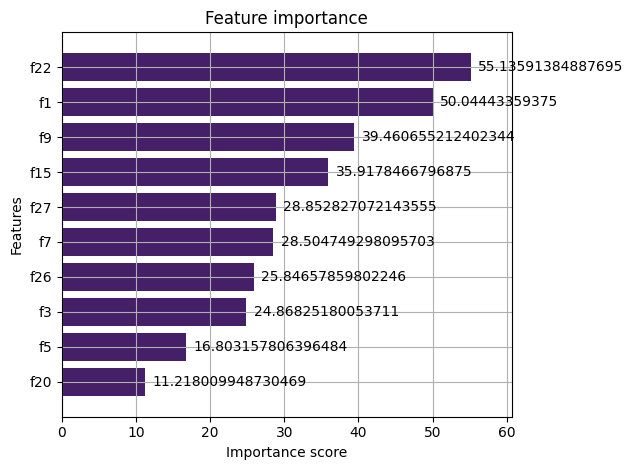

In [8]:
plot_importance(
    best_model_2,
    importance_type='gain',
    max_num_features=10,
    color="#451F68",  
    height=0.8
)
plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

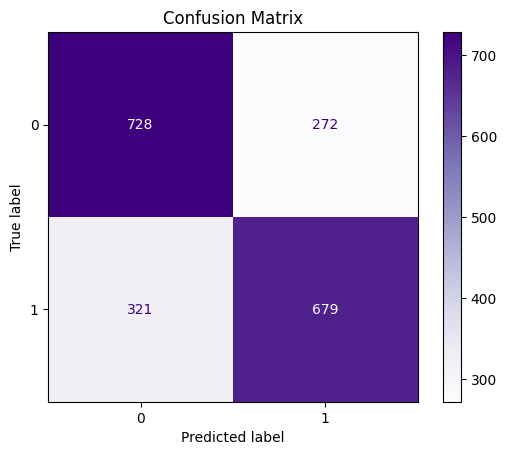

<Figure size 600x500 with 0 Axes>

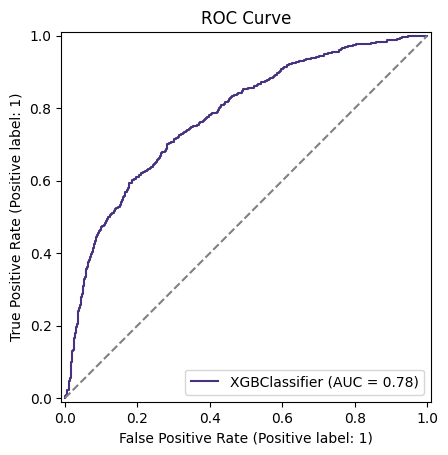

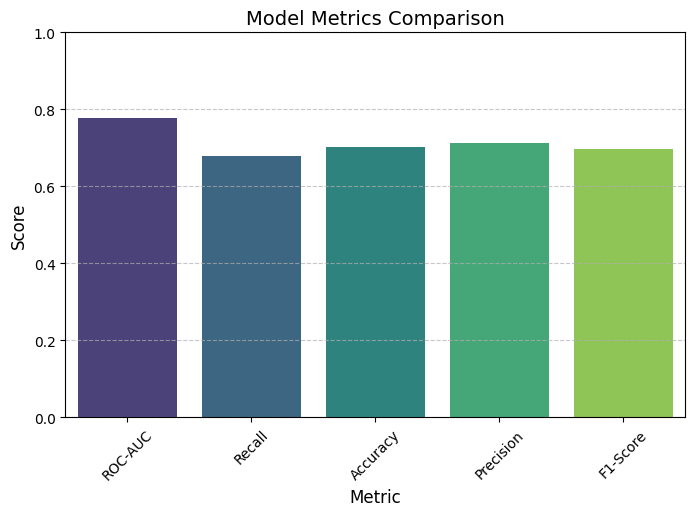

In [9]:
metrics = {
    "ROC-AUC": roc_auc_score(y_test, y_score_2),
    "Recall": recall_score(y_test, y_pred_2),
    "Accuracy": accuracy_score(y_test, y_pred_2),
    "Precision": precision_score(y_test, y_pred_2),
    "F1-Score": f1_score(y_test, y_pred_2),
}

conf_mat = confusion_matrix(y_test, y_pred_2)

sns.set_palette("viridis")    #style graph

# 1. Confusion Matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(conf_mat).plot(cmap="Purples")
plt.title("Confusion Matrix")
plt.show()

# 2. ROC Curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(best_model_2, X_test, y_test)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")      # classif label 50/50
plt.title("ROC Curve")
plt.show()

# 3. Bar Plot metric
plt.figure(figsize=(8, 5))
sns.barplot(
    x=list(metrics.keys()), 
    y=list(metrics.values()),
    palette="viridis"               #  "husl", "mako", "rocket", "flare" 
)
plt.title("Model Metrics Comparison", fontsize=14)
plt.ylim(0, 1)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

In [ ]:
# load best model
loaded_model = joblib.load('best_xgboost_model.pkl')

y_pred = loaded_model.predict(X_val)
y_pred.shape
df_valid['Target'] = y_pred

print(np.isin(y_pred, 1).sum())
df_valid.head()

df_valid.to_excel('forecast_2.xlsx')

4492


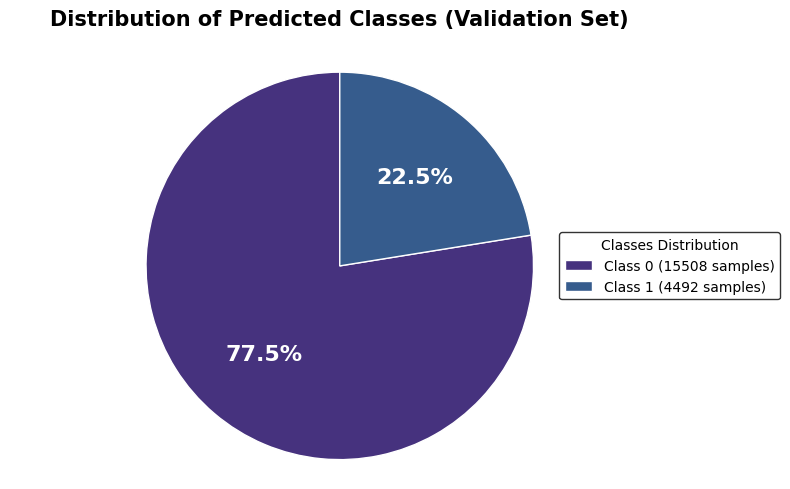

In [20]:
# Count class
class_counts = df_valid['Target'].value_counts()
labels = ['Class 0', 'Class 1']
sizes = class_counts.values
palette = sns.color_palette("viridis")

plt.figure(figsize=(8, 5))
wedges, texts, autotexts = plt.pie(
    sizes, 
    colors=palette,
    labels=labels, 
    autopct='%1.1f%%',  
    startangle=90,      
    shadow=False,        
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'color': 'white', 'fontsize': 16, 'fontweight': 'bold'}   
)

plt.legend(
    wedges,
    [f'{label} ({count} samples)' for label, count in zip(labels, sizes)],
    title="Classes Distribution",
    loc="center",
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    edgecolor='black'
)

plt.title('Distribution of Predicted Classes (Validation Set)', 
          fontsize=15, pad=20, fontweight='bold', loc='center')

plt.axis('equal')
plt.tight_layout()
plt.show()